In [9]:
estimator_name='deepdb'

In [11]:
addr="./lecarb/estimator/predict_result/"+estimator_name+"_model_prediction/valid_"+"forest10"+"_"+'original'+".pkl"
    
with open(addr, 'rb') as f:
    [prediction,label,data_length] = pickle.load(f)
print(data_length)

581012


In [2]:
import pickle
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# dataset='census1a3'
# version='original'


def drawing(dataset,version,estimator_name):
    result_addr="./lecarb/estimator/mine/tree_inference_result/valid_"+dataset+"_"+version+".pkl"
    with open(result_addr, 'rb') as f:
        [inference_result,inference_time] = pickle.load(f)

    addr="./lecarb/estimator/predict_result/"+estimator_name+"_model_prediction/valid_"+dataset+"_"+version+".pkl"
    
    with open(addr, 'rb') as f:
        [prediction,label,data_length] = pickle.load(f)
        
        
    prediction=[prediction[i]/data_length for i in range(len(prediction))]


    count_prediction=[float(i) for i in prediction]

    prediction_values=sorted(Counter(count_prediction).keys(),key=lambda x:x,reverse=False)
#     label=np.around(label*data_length)

    

    loss=[] 
    t=[]
    mean_qerror=[]
    for threshold in prediction_values:
        add_time=0
        q_error=[]
        for i in range(len(prediction)):
            if prediction[i]<=threshold:
                q_error.append(1)
                add_time+=inference_time[i]
            else:
                p=np.around(prediction[i]*data_length)
                
                
                l=label[i]
                if p==0 and l==0:
                    q_error.append(1)
                elif p==0:
                    q_error.append(l)
                elif l==0:
                    q_error.append(p)
                else:
                    q_error.append(max(p/l,l/p))
        add_time=add_time*1000/10000
       
        loss.append(add_time+np.mean(q_error))
        t.append(add_time)
        mean_qerror.append(np.mean(q_error))
#     print("best eta:",prediction_values[loss.index(min(loss))])
    
#     threshold=prediction_values[loss.index(min(loss))]
#     add_time=0
#     q_error=[]
#     turn_to_precise=0
#     for i in range(len(prediction)):
#         if prediction[i]<=threshold:
#             turn_to_precise+=1
#             q_error.append(1)
#             add_time+=inference_time[i]
#         else:
#             p=np.around(prediction[i]*data_length)
#             l=label[i]
#             if p==0 and l==0:
#                 q_error.append(1)
#             elif p==0:
#                 q_error.append(l)
#             elif l==0:
#                 q_error.append(p)
#             else:
#                 q_error.append(max(p/l,l/p))
#     add_time=add_time*1000/10000
#     print("max:",np.max(q_error),'99th:',np.percentile(q_error,99),'95th:',np.percentile(q_error,95),'90th:',np.percentile(q_error,90),'75th:',np.percentile(q_error,75),'50th:',np.percentile(q_error,50),'25th:',np.percentile(q_error,25),'mean:',np.mean(q_error))
#     print("average time:",add_time,"ms/query")
#     print("turn_to_precise",turn_to_precise)
    
#     plt.xlabel('eta')
#     plt.ylabel('loss')
#     plt.plot(prediction_values,loss)
#     plt.show()
    
#     plt.xlabel('eta')
#     plt.ylabel('incremented time of using tree')
#     plt.plot(prediction_values,t)
#     plt.show()
    
#     plt.xlabel('eta')
#     plt.ylabel('mean q_error after using tree')
#     plt.plot(prediction_values,mean_qerror)
#     plt.show()
    
    return prediction_values,loss,t,mean_qerror

In [3]:
import numpy as np
from scipy.optimize import curve_fit,minimize
import matplotlib.pyplot as mpl

from sympy import symbols, diff
from sympy.functions import exp

def func1_for_diff(a,x0,sigma):
    x=symbols('x')
    f=a*exp(-(x-x0)**2/(2*sigma**2))
    derivative_f = diff(f, x)
    return f,derivative_f

def func2_for_diff(a,x0,sigma):
    x=symbols('x')
    f=a*exp(-(x-x0)**2/(2*sigma**2))+1
    derivative_f = diff(f, x)
    return f,derivative_f

# Let's create a function to model and create data
def func1(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def func2(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+1

def exponen(x,a,b,lamb):
    if type(x)==type([]):
        x=np.array(x)
    return a-b*np.exp(-(lamb*x))

def exponen_for_diff(a,b,lamb):
    x=symbols('x')
    f=a-b*exp(-(lamb*x))
    derivative_f = diff(f, x)
    return f,derivative_f

def fit2(x,y,fit_type):
    plt.plot(x, y, c='k', label='data')
    plt.scatter(x, y)
    if fit_type==1:
        popt, pcov = curve_fit(exponen, x, y,maxfev=1000000)
        ym = exponen(x, popt[0], popt[1], popt[2])
    elif fit_type==2:
        popt, pcov = curve_fit(func2, x, y,maxfev=1000000)
        ym = func2(x, popt[0], popt[1], popt[2])
    else:
        print("wrong type")
        return
        
    #popt returns the best fit values for parameters of the given model (func)

    plt.plot(x, ym, c='r', label='fit')
    plt.legend()
    plt.show()
    return popt

def exponent_func(a,b,lamb):
    f=lambda x:a-b*np.exp(-(lamb*x))
    return f

def func2_func(a,x0,sigma):
    f=lambda x:a*np.exp(-(x-x0)**2/(2*sigma**2))+1
    return f



In [4]:
def fit_and_find_best_eta(prediction_values,t,mean_qerror):
    x=symbols('x')
    popt1=fit2(prediction_values,t,fit_type=1)
    popt2=fit2(prediction_values,mean_qerror,fit_type=2)
    f1,_=exponen_for_diff(popt1[0],popt1[1],popt1[2])
    f2,_=func2_for_diff(popt2[0],popt2[1],popt2[2])
    f=f1+f2
    print(f)
    print("-----------------")
    
    func_f1=exponent_func(popt1[0],popt1[1],popt1[2])
    func_f2=func2_func(popt2[0],popt2[1],popt2[2])
    func_f=lambda x:func_f1(x)+func_f2(x)
    result=minimize(func_f,x0=[0.5],method='SLSQP',bounds=[(0,1)])

    a=[i/10000 for i in range(0,10000)]
    b=[f.subs(x,i) for i in a]
    plt.plot(a,b)
    best_eta=result['x'][0]
    print("best eta:",best_eta)
#     print("loss:",f.subs(x,best_eta))
#     print("time:",f1.subs(x,best_eta))
#     print("mean_qerror:",f2.subs(x,best_eta))
    plt.scatter(result['x'][0],f.subs(x,result['x'][0]),color='r')
    plt.show()
    return best_eta


def test_for_best_eta(dataset,version,best_eta,estimator_name):
    result_addr="./lecarb/estimator/mine/tree_inference_result/valid_"+dataset+"_"+version+".pkl"
    with open(result_addr, 'rb') as f:
        [inference_result,inference_time] = pickle.load(f)

    addr="./lecarb/estimator/predict_result/"+estimator_name+"_model_prediction/valid_"+dataset+"_"+version+".pkl"
    
    with open(addr, 'rb') as f:
        [prediction,label,data_length] = pickle.load(f)
        
        
    prediction=[prediction[i]/data_length for i in range(len(prediction))]


    count_prediction=[float(i) for i in prediction]

    prediction_values=sorted(Counter(count_prediction).keys(),key=lambda x:x,reverse=False)  
#label=np.around(label*data_length)
    
    
    add_time=0
    q_error=[]
    turn_to_precise=0
    for i in range(len(prediction)):
        if prediction[i]<=best_eta:
            q_error.append(1)
            turn_to_precise+=1
            add_time+=inference_time[i]
        else:
            p=np.around(prediction[i]*data_length)
            l=label[i]
            if p==0 and l==0:
                q_error.append(1)
            elif p==0:
                q_error.append(l)
            elif l==0:
                q_error.append(p)
            else:
                q_error.append(max(p/l,l/p))
    add_time=add_time*1000/10000
    print("max:",np.max(q_error),'99th:',np.percentile(q_error,99),'95th:',np.percentile(q_error,95),'90th:',np.percentile(q_error,90),'75th:',np.percentile(q_error,75),'50th:',np.percentile(q_error,50),'25th:',np.percentile(q_error,25),'mean:',np.mean(q_error))
    print("average incremental time:",add_time,"ms/query")
    print("turn_to_precise",turn_to_precise)
    


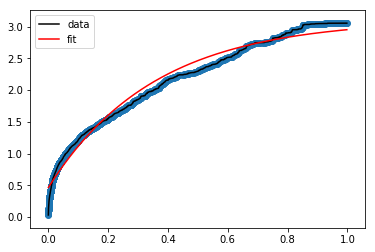

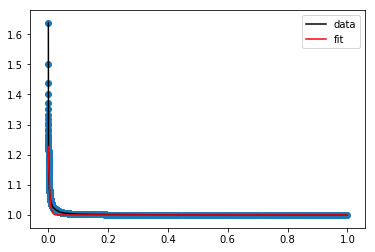

2.05572476324699 + 2.39992786755782e+157*exp(-38.2684015576667*(x + 3.08647543044054)**2) - 1.32307633190295*exp(-2.82119370849153*x)
-----------------
best eta: 0.008443939625411012


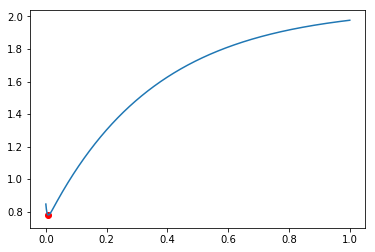

max: 4.877049180327869 99th: 1.700830706179067 95th: 1.2504404563265543 90th: 1.1044865184096146 75th: 1.002395770943465 50th: 1.0 25th: 1.0 mean: 1.0427490894703613
average incremental time: 0.4447582244873047 ms/query
turn_to_precise 6484


In [5]:
dataset='census13'
prediction_values,loss,t,mean_qerror=drawing(dataset,'original',estimator_name)
best_eta=fit_and_find_best_eta(prediction_values,t,mean_qerror)
test_for_best_eta(dataset,'original',best_eta,estimator_name)

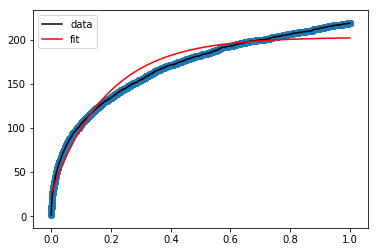

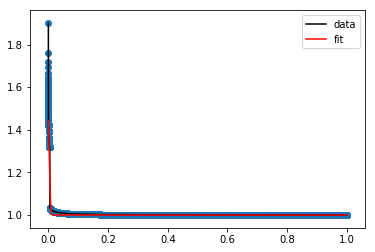

101.87700526126 + 0.230083210336465*exp(-27850.4512215099*(x + 0.00118462510030761)**2) - 88.2178481384674*exp(-5.36890759173569*x)
-----------------
best eta: 0.0


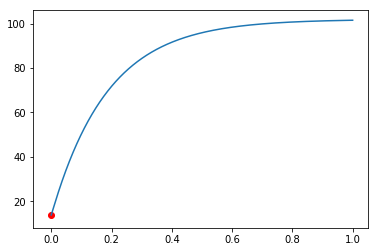

max: 2851.0 99th: 10.0 95th: 3.367729591836729 90th: 2.0 75th: 1.2439392176574169 50th: 1.0364906083777528 25th: 1.0 mean: 1.9003272948276693
average incremental time: 1.4332772493362427 ms/query
turn_to_precise 1802


In [6]:
dataset='forest10'
prediction_values,loss,t,mean_qerror=drawing(dataset,'original',estimator_name)
best_eta=fit_and_find_best_eta(prediction_values,t,mean_qerror)
test_for_best_eta(dataset,'original',best_eta,estimator_name)

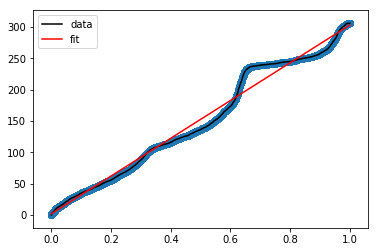

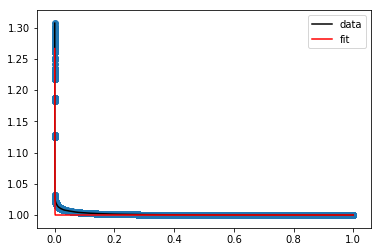

625485.147033859 + 0.162749841856462*exp(-2659280.06918149*(x + 0.000274385055856276)**2) - 625483.637518961*exp(-0.000240899706832114*x)
-----------------
best eta: 0.00046214956543683133


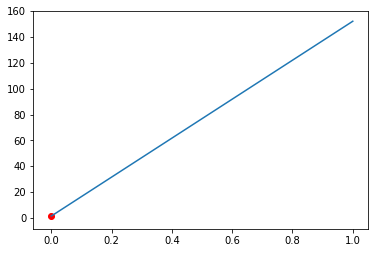

max: 25.557692307692307 99th: 1.4878218583074496 95th: 1.1432427054026704 90th: 1.0649916791057394 75th: 1.0105454211207094 50th: 1.0003316941006974 25th: 1.0 mean: 1.0313092002982913
average incremental time: 1.063762092590332 ms/query
turn_to_precise 973


In [7]:
dataset='power7'
prediction_values,loss,t,mean_qerror=drawing(dataset,'original',estimator_name)
best_eta=fit_and_find_best_eta(prediction_values,t,mean_qerror)
test_for_best_eta(dataset,'original',best_eta,estimator_name)

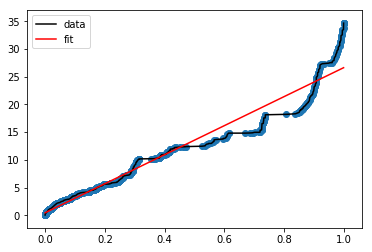

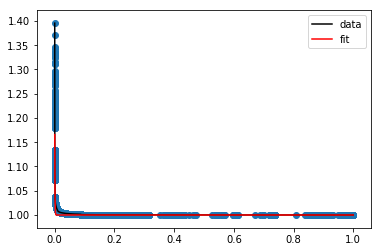

52013.7153199266 + 3.1026597026161e+124*exp(-1660.60523416727*(x + 0.417275885580399)**2) - 52012.9887301038*exp(-0.00025151229844548*x)
-----------------
best eta: 0.0015720891266910683


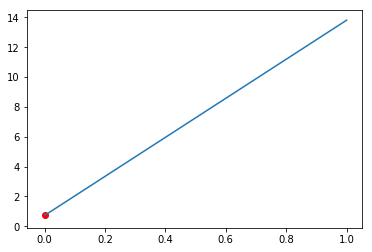

max: 3.998708844415752 99th: 1.291893137963162 95th: 1.160940288269084 90th: 1.1068659087892856 75th: 1.0278374431516422 50th: 1.0012110154741019 25th: 1.0 mean: 1.0301597153558262
average incremental time: 0.3004714012145996 ms/query
turn_to_precise 3321


In [8]:
dataset='dmv11'
prediction_values,loss,t,mean_qerror=drawing(dataset,'original',estimator_name)
best_eta=fit_and_find_best_eta(prediction_values,t,mean_qerror)
test_for_best_eta(dataset,'original',best_eta,estimator_name)